In [105]:
# ECG Model Interactive Debugging Notebook
# This notebook allows you to debug flat line predictions by monitoring training components

import os
import sys
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader,ConcatDataset
from types import SimpleNamespace


# Setup paths - adjust ROOT_DIR to your project root
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf'
BIN_DIR = f'{ROOT_DIR}/bin'
DATA_DIR = f'{ROOT_DIR}/data'
import os
import sys
sys.path.append(ROOT_DIR)
sys.path.append(BIN_DIR)
# Add bin directory to path and change working directory
os.chdir(BIN_DIR)


# Add bin directory to path and change working directory
sys.path.append(BIN_DIR)
os.chdir(BIN_DIR)

# Import your modules
from flower.task import Net
from flower.model_config import get_model_config
from lib.physionet import variable_time_collate_fn, get_data_min_max
from lib import utils
from lib.plot import plot_trajectories

# Configure matplotlib for inline plotting
%matplotlib inline
%load_ext autoreload
%autoreload 2

# ==========================================
# CONFIGURATION SECTION
# ==========================================

# Model configuration based on ecg_simulation.config
CONFIG = {
    'id': 'ecg_physionet_debug',
    'dataset_name': 'ecg_physionet_level0_iid',  # Adjust as needed
    'data_folder': '.',
    'lr': 0.001,
    'lrdecay': 0.99,
    'batch_size': 64,  # Smaller batch for easier debugging
    'sample_tp': 1,
    'cut_tp': 'false',
    'extrap': 'false',
    'gradientclipping': 'True',
    'storeweights': 'false',
    'obsrv_std': 0.01,
    'poisson': 'false',
    'rec_layers': 6,
    'gen_layers': 6,
    'units': 100,
    'gru_units': 100,
    'latents': 100,
    'rec_dims': 100,
    'z0_encoder': 'odernn',
    'train_classif_w_reconstr': 'false',
    'classif': 'false',
    'linear_classif': 'false',
    'classif_per_tp': 'false',
    'n_labels': 1,
    'input_dim': 12,
    'epochs': 50,  # More epochs for better debugging
    'solver_method': 'tsit5',           # Stiff-capable solver for ECG
    'encoder_solver_method': 'tsit5',   # Simple solver for encoder
    'use_jit': 'true',                  # Enable JIT compilation
    'ode_rtol': '1e-5',                 # Tight relative tolerance
    'ode_atol': '1e-7'  
}

# Data paths - adjust to your ECG data location
CLIENT_ID = 0  # Which client's data to use
DATA_BASE_DIR = os.path.join(ROOT_DIR, 'data', 'ecg_physionet', 'splits')
DATASET_NAME = CONFIG['dataset_name']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# ==========================================
# SETUP FUNCTIONS
# ==========================================

def create_model_config():
    """Create temporary model.config file with debugging configuration"""
    config_path = os.path.join(BIN_DIR, 'model.config')
    with open(config_path, 'w') as f:
        for key, value in CONFIG.items():
            f.write(f"{key},{value}\n")
    print(f"Created model config at: {config_path}")
    return config_path

def load_data(client_id=0):
    """Load ECG data for specified client"""
    # Construct data paths
    train_path = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{client_id}_train.pt')
    test_path = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{client_id}_test.pt')
    data_min_path = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{client_id}_data_min.pt')
    data_max_path = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{client_id}_data_max.pt')
    
    print(f"Loading data from: {train_path}")
    
    # Load datasets
    train_dataset = torch.load(train_path, weights_only=False)
    test_dataset = torch.load(test_path, weights_only=False)
    # For debugging just want to maximise training data
    train_dataset = ConcatDataset([train_dataset, test_dataset])
    
    # Load or compute data normalization
    if os.path.exists(data_min_path) and os.path.exists(data_max_path):
        data_min = torch.load(data_min_path, weights_only=False)
        data_max = torch.load(data_max_path, weights_only=False)
    else:
        print("Computing data min/max...")
        total_dataset = train_dataset + test_dataset
        data_min, data_max = get_data_min_max(total_dataset)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Data min: {data_min.shape}, Data max: {data_max.shape}")
    
    return train_dataset, test_dataset, data_min, data_max

def create_dataloaders(train_dataset, test_dataset, data_min, data_max, batch_size=16):
    """Create dataloaders with ECG-specific collate function"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Setup args for physionet
    args_physionet = SimpleNamespace()
    args_physionet.sample_tp = CONFIG['sample_tp']
    args_physionet.cut_tp = None
    args_physionet.extrap = None
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=lambda batch: variable_time_collate_fn(
            batch, args_physionet, device, data_type="train",
            data_min=data_min, data_max=data_max
        )
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=lambda batch: variable_time_collate_fn(
            batch, args_physionet, device, data_type="test",
            data_min=data_min, data_max=data_max
        )
    )
    
    return train_loader, test_loader

# ==========================================
# DEBUGGING FUNCTIONS
# ==========================================

def inspect_batch(batch_dict, title="Batch Inspection"):
    """Inspect a single batch to understand data structure"""
    print(f"\n=== {title} ===")
    for key, value in batch_dict.items():
        if key != 'labels':
            if isinstance(value, torch.Tensor):
                print(f"{key}: {value.shape}, dtype: {value.dtype}")
                print(f"  Min: {value.min().item():.4f}, Max: {value.max().item():.4f}")
                print(f"  Mean: {value.mean().item():.4f}, Std: {value.std().item():.4f}")
                if torch.isnan(value).any():
                    print(f"  WARNING: Contains NaN values!")
                if torch.isinf(value).any():
                    print(f"  WARNING: Contains Inf values!")
            else:
                print(f"{key}: {type(value)}")
        print()

def plot_sample_ecg_data(batch_dict, n_samples=3):
    """Plot sample ECG trajectories from a batch"""
    data = batch_dict["observed_data"]  # [batch, time, channels]
    time_steps = batch_dict["observed_tp"]  # [batch, time]
    
    n_samples = min(n_samples, data.shape[0])
    n_channels = min(4, data.shape[2])  # Plot first 4 ECG leads
    
    fig, axes = plt.subplots(n_samples, n_channels, figsize=(20, 3*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    if n_channels == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        for j in range(n_channels):
            ax = axes[i, j]
            
            # Get valid time points (non-NaN)
            valid_mask = ~torch.isnan(data[i, :, j])
            if valid_mask.sum() > 0:
                valid_times = time_steps[valid_mask].cpu()
                valid_values = data[i, valid_mask, j].cpu()
                
                ax.plot(valid_times, valid_values, 'o-', alpha=0.7, markersize=3)
                ax.set_title(f'ECG Sample {i}, Lead {j}')
                ax.set_xlabel('Time')
                ax.set_ylabel('ECG Value')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

def detailed_training_step(model, batch_dict, optimizer, kl_coef=1.0):
    """Perform one training step with detailed loss breakdown for time series reconstruction"""
    optimizer.zero_grad()
    
    # Forward pass with loss computation
    results = model.compute_all_losses(batch_dict, kl_coef=kl_coef)
    
    # Backward pass
    loss = results["loss"]
    loss.backward()
    optimizer.step()
    
    # Extract detailed metrics for time series reconstruction
    metrics = {
        'total_loss': loss.item(),
        'reconstruction_loss': -results["likelihood"].item(),  # Negative log likelihood
        'kl_divergence': results["kl_first_p"].item(),
        'mse': results["mse"].item(),
        'deriv_loss': results["deriv_loss"].item(),
        'nodesolve': results.get("nodesolve", 0),
        'fp_std': results.get("std_first_p", 0).item() if hasattr(results.get("std_first_p", 0), 'item') else results.get("std_first_p", 0)
    }
    
    return metrics

def get_model_predictions(model, batch_dict):
    """Get model predictions and latent representations"""
    model.eval()
    with torch.no_grad():
        # Get reconstructions
        pred_y, info = model.get_reconstruction(
            batch_dict["tp_to_predict"], 
            batch_dict["observed_data"], 
            batch_dict["observed_tp"],
            mask=batch_dict["observed_mask"],
            n_traj_samples=1
        )
        
        # Extract latent trajectory if available
        latent_traj = info.get("latent_traj", None)
        first_point = info.get("first_point", (None, None, None))
        
    model.train()
    return pred_y, latent_traj, first_point

def plot_ecg_reconstructions(batch_dict, pred_y, n_samples=1, n_channels=4):
    """Plot ECG reconstructions vs ground truth for multiple channels"""
    truth = batch_dict["data_to_predict"]  # [batch, time, channels]
    observed_data = batch_dict["observed_data"]  # [batch, time, channels] 
    observed_tp = batch_dict["observed_tp"]  # [batch, time]
    time_pred = batch_dict["tp_to_predict"]  # [batch, time]
    
    n_samples = min(n_samples, truth.shape[0])
    n_channels = min(n_channels, truth.shape[2])
    
    fig, axes = plt.subplots(n_samples, n_channels, figsize=(20, 3*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    if n_channels == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        for j in range(n_channels):
            ax = axes[i, j]
            
            # Ground truth (full prediction timespan)
            truth_vals = truth[i, :, j].cpu()
            pred_vals = pred_y[0, i, :, j].cpu()  # [n_traj_samples, batch, time, features]
            times_pred = time_pred.cpu()
            
            # Observed data points (conditioning data)
            observed_vals = observed_data[i, :, j].cpu()
            times_obs = observed_tp.cpu()
            
            # Plot observed points (what model conditions on)
            valid_obs = ~torch.isnan(observed_vals)
            if valid_obs.sum() > 0:
                ax.scatter(times_obs[valid_obs], observed_vals[valid_obs], 
                          c='blue', s=5, alpha=0.1, label='Observed', zorder=3)
            
            # Plot ground truth trajectory
            valid_truth = ~torch.isnan(truth_vals)
            if valid_truth.sum() > 0:
                ax.plot(times_pred[valid_truth], truth_vals[valid_truth], 
                       'g-', linewidth=2, alpha=0.3, label='Ground Truth')
            
            # Plot reconstruction
            valid_pred = ~torch.isnan(pred_vals)
            if valid_pred.sum() > 0:
                ax.plot(times_pred[valid_pred], pred_vals[valid_pred], 
                       'r--', linewidth=2, alpha=0.8, label='Reconstruction')
            
            ax.set_title(f'ECG Sample {i}, Lead {j}')
            if j == 0:  # Only show legend on first channel to avoid clutter
                ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time')
            ax.set_ylabel('ECG Value')
    
    plt.tight_layout()
    plt.show()
    
def plot_predictions_vs_truth(batch_dict, pred_y, n_samples=2):
    """Plot model predictions vs ground truth"""
    truth = batch_dict["data_to_predict"]
    time_pred = batch_dict["tp_to_predict"]
    
    n_samples = min(n_samples, truth.shape[0])
    n_features = min(3, truth.shape[2])
    
    fig, axes = plt.subplots(n_samples, n_features, figsize=(15, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    if n_features == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        for j in range(n_features):
            ax = axes[i, j]
            
            # Plot truth
            truth_vals = truth[i, :, j].cpu()
            pred_vals = pred_y[0, i, :, j].cpu()  # [n_traj_samples, batch, time, features]
            times = time_pred[i].cpu()
            
            ax.plot(times, truth_vals, 'b-', label='Truth', alpha=0.7)
            ax.plot(times, pred_vals, 'r--', label='Prediction', alpha=0.7)
            
            ax.set_title(f'Sample {i}, Feature {j}')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
def plot_ecg_prediction_quality(batch_dict, pred_y):
    """Analyze ECG prediction quality with error metrics"""
    truth = batch_dict["data_to_predict"]
    pred = pred_y[0]  # Take first sample
    
    # Compute channel-wise MSE
    mse_per_channel = torch.mean((truth - pred)**2, dim=(0, 1))  # Average over batch and time
    
    # Compute overall statistics
    overall_mse = torch.mean((truth - pred)**2).item()
    overall_mae = torch.mean(torch.abs(truth - pred)).item()
    
    # Plot MSE per ECG lead
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(mse_per_channel)), mse_per_channel.cpu())
    plt.title('MSE per ECG Lead')
    plt.xlabel('ECG Lead')
    plt.ylabel('MSE')
    plt.xticks(range(len(mse_per_channel)))
    
    # Plot error distribution
    plt.subplot(1, 2, 2)
    errors = (truth - pred).flatten().cpu()
    plt.hist(errors, bins=50, alpha=0.7, density=True)
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Error (Truth - Prediction)')
    plt.ylabel('Density')
    plt.axvline(0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall MSE: {overall_mse:.6f}")
    print(f"Overall MAE: {overall_mae:.6f}")
    print(f"Error std: {errors.std().item():.6f}")
    
    return mse_per_channel.cpu().numpy()

def plot_latent_trajectories(latent_traj, time_steps, n_samples=2):
    """Plot latent space trajectories"""
    if latent_traj is None:
        print("No latent trajectories available")
        return
    
    # latent_traj shape: [n_traj_samples, batch, time, latent_dim]
    n_samples = min(n_samples, latent_traj.shape[1])
    n_latent = min(4, latent_traj.shape[3])  # Plot first 4 latent dimensions
    
    fig, axes = plt.subplots(n_samples, n_latent, figsize=(20, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    if n_latent == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        for j in range(n_latent):
            ax = axes[i, j]
            
            latent_vals = latent_traj[0, i, :, j].cpu()  # First trajectory sample
            times = time_steps.cpu()
            
            ax.plot(times, latent_vals, 'g-', alpha=0.7)
            ax.set_title(f'Sample {i}, Latent Dim {j}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Latent Value')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN DEBUGGING PIPELINE
# ==========================================

def debug_training_pipeline():
    """Main debugging function that runs a complete training pipeline with monitoring"""
    
    print("=== ECG Model Debugging Pipeline ===\n")
    
    # 1. Setup
    print("1. Setting up configuration...")
    config_path = create_model_config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 2. Load data
    print("\n2. Loading data...")
    train_dataset, test_dataset, data_min, data_max = load_data(CLIENT_ID)
    train_loader, test_loader = create_dataloaders(
        train_dataset, test_dataset, data_min, data_max, CONFIG['batch_size']
    )
    
    # 3. Initialize model
    print("\n3. Initializing model...")
    model = Net()
    model.to(device)
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # 4. Setup optimizer
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    
    # 5. Inspect a sample batch
    print("\n4. Inspecting sample ECG batch...")
    sample_batch = next(iter(train_loader))
    inspect_batch(sample_batch, "Training Batch")
    plot_sample_ecg_data(sample_batch, n_samples=2)
    
    # 6. Check initial predictions
    print("\n5. Checking initial ECG predictions (before training)...")
    pred_y, latent_traj, first_point = get_model_predictions(model, sample_batch)
    print(f"Prediction shape: {pred_y.shape}")
    print(f"Input ECG shape: {sample_batch['observed_data'].shape}")
    print(f"Target ECG shape: {sample_batch['data_to_predict'].shape}")
    
    plot_ecg_reconstructions(sample_batch, pred_y, n_samples=2)
    plot_ecg_prediction_quality(sample_batch, pred_y)
    plot_latent_trajectories(latent_traj, sample_batch["tp_to_predict"], n_samples=2)
    
    # 7. Training loop with monitoring
    print("\n6. Starting training with detailed monitoring...")
    
    n_epochs = CONFIG['epochs']
    n_batches = len(train_loader)
    
    # Tracking variables
    train_metrics = []
    kl_coef = 0.0  # Start with no KL penalty
    
    for epoch in range(n_epochs):
        model.train()
        epoch_metrics = []
        
        # KL annealing schedule
        if epoch >= 10:  # Start KL after 10 epochs
            kl_coef = min(1.0, (epoch - 10) / 20.0)  # Gradually increase to 1.0
        
        train_loader_inf = utils.inf_generator(train_loader)
        
        for batch_idx in range(n_batches):
            batch_dict = next(train_loader_inf)
            
            # Detailed training step
            metrics = detailed_training_step(model, batch_dict, optimizer, kl_coef)
            metrics['epoch'] = epoch
            metrics['batch'] = batch_idx
            metrics['kl_coef'] = kl_coef
            epoch_metrics.append(metrics)
            
            # Print progress for time series reconstruction
            if batch_idx % max(1, n_batches // 5) == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}/{n_batches}: "
                      f"Loss={metrics['total_loss']:.4f}, "
                      f"Recon={metrics['reconstruction_loss']:.4f}, "
                      f"KL={metrics['kl_divergence']:.4f}, "
                      f"MSE={metrics['mse']:.4f}, "
                      f"Deriv={metrics['deriv_loss']:.4f}, ",
                      f"FP_std={metrics['fp_std']:.4f}")
        
        train_metrics.extend(epoch_metrics)
        
        # Plot ECG reconstructions every 10 epochs
        print(f"\n--- Epoch {epoch} ECG Reconstructions ---")
        pred_y, latent_traj, first_point = get_model_predictions(model, sample_batch)
        plot_ecg_reconstructions(sample_batch, pred_y, n_samples=2)
        mse_per_lead = plot_ecg_prediction_quality(sample_batch, pred_y)
        plot_latent_trajectories(latent_traj, sample_batch["tp_to_predict"], n_samples=2)

    # 8. Plot training curves for time series reconstruction
    print("\n7. Plotting ECG reconstruction training curves...")
    df_metrics = pd.DataFrame(train_metrics)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Total loss
    axes[0, 0].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['total_loss'])
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Reconstruction vs KL
    axes[0, 1].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['reconstruction_loss'], label='Reconstruction')
    axes[0, 1].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['kl_divergence'], label='KL Divergence')
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # MSE
    axes[0, 2].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['mse'])
    axes[0, 2].set_title('MSE (ECG Reconstruction Error)')
    axes[0, 2].set_ylabel('MSE')
    axes[0, 2].grid(True, alpha=0.3)
    
    # KL coefficient
    axes[1, 0].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['kl_coef'])
    axes[1, 0].set_title('KL Coefficient (Annealing)')
    axes[1, 0].set_ylabel('KL Coef')
    axes[1, 0].grid(True, alpha=0.3)
    
    # First point std (latent space uncertainty)
    axes[1, 1].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['fp_std'])
    axes[1, 1].set_title('Latent Initial State Std')
    axes[1, 1].set_ylabel('Std')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Node solves (ODE solver steps)
    if 'nodesolve' in df_metrics.columns:
        axes[1, 2].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['nodesolve'])
        axes[1, 2].set_title('ODE Solver Steps')
        axes[1, 2].set_ylabel('Steps')
        axes[1, 2].grid(True, alpha=0.3)
    
    for ax in axes.flat:
        ax.set_xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    # 9. Final evaluation
    print("\n8. Final evaluation...")
    model.eval()
    test_batch = next(iter(test_loader))
    inspect_batch(test_batch, "Test Batch")
    
    final_pred, final_latent, final_first = get_model_predictions(model, test_batch)
    plot_predictions_vs_truth(test_batch, final_pred, n_samples=3)
    plot_latent_trajectories(final_latent, test_batch["tp_to_predict"], n_samples=3)
    
    # Cleanup
    if os.path.exists(config_path):
        os.remove(config_path)
    
    return model, df_metrics

=== ECG Model Debugging Pipeline ===

1. Setting up configuration...
Created model config at: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/bin/model.config
Using device: cuda

2. Loading data...
Loading data from: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/data/ecg_physionet/splits/ecg_physionet_level0_iid/client_0_train.pt
Train dataset size: 7201
Test dataset size: 1441
Data min: torch.Size([12]), Data max: torch.Size([12])

3. Initializing model...
TorchODE solvers are natively JIT-compatible
Model created with 311012 parameters

4. Inspecting sample ECG batch...

=== Training Batch ===
observed_data: torch.Size([64, 1000, 12]), dtype: torch.float32
  Min: 0.3128, Max: 2.5352
  Mean: 1.1274, Std: 0.4965

observed_tp: torch.Size([1000]), dtype: torch.float32
  Min: 0.0000, Max: 1.0000
  Mean: 0.5000, Std: 0.2891

data_to_predict: torch.Size([64, 1000, 12]), dtype: torch.float32
  Min: 0.3128, Max: 2.5352
  Mean: 1.1274, Std: 0.4965

tp_to_predict: torch.Size([1000]), dtyp

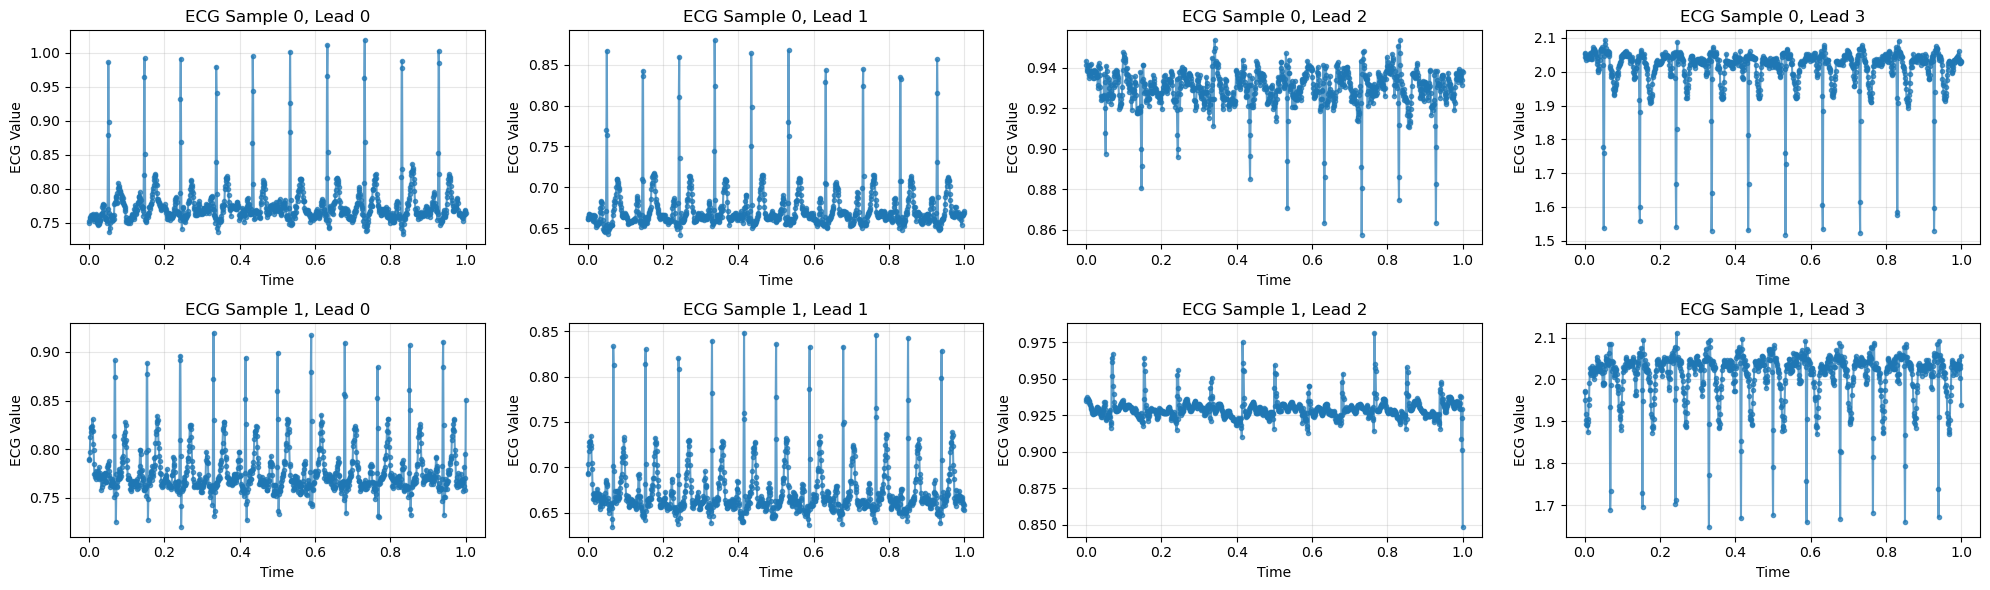


5. Checking initial ECG predictions (before training)...
Prediction shape: torch.Size([1, 64, 1000, 12])
Input ECG shape: torch.Size([64, 1000, 12])
Target ECG shape: torch.Size([64, 1000, 12])


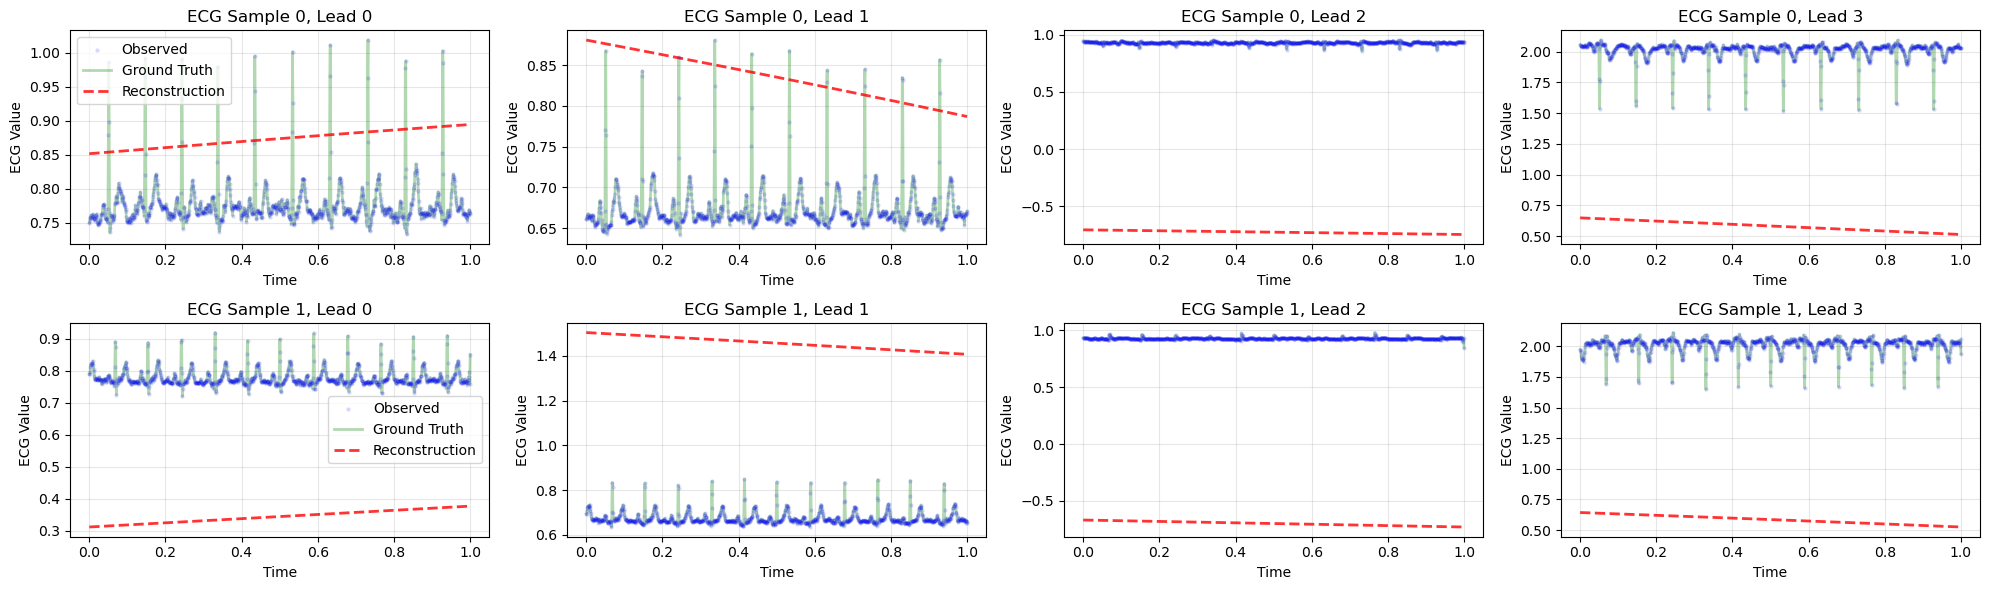

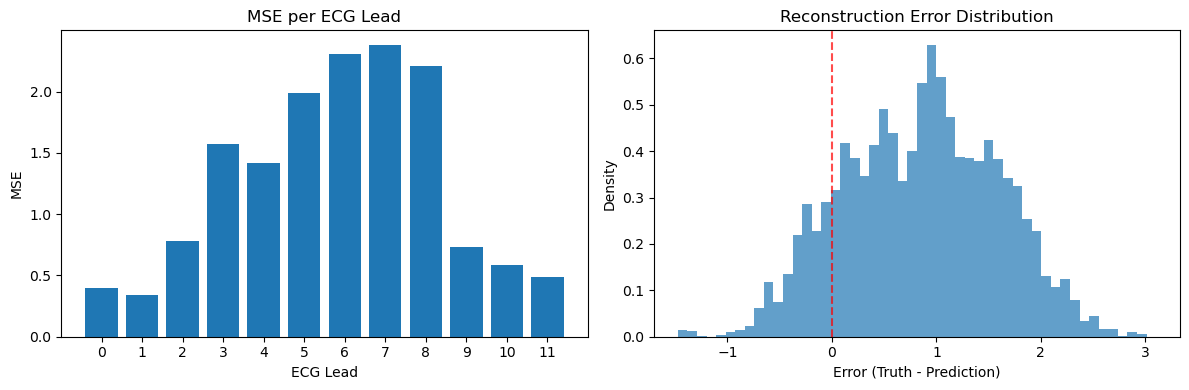

Overall MSE: 1.266486
Overall MAE: 0.937520
Error std: 0.738511


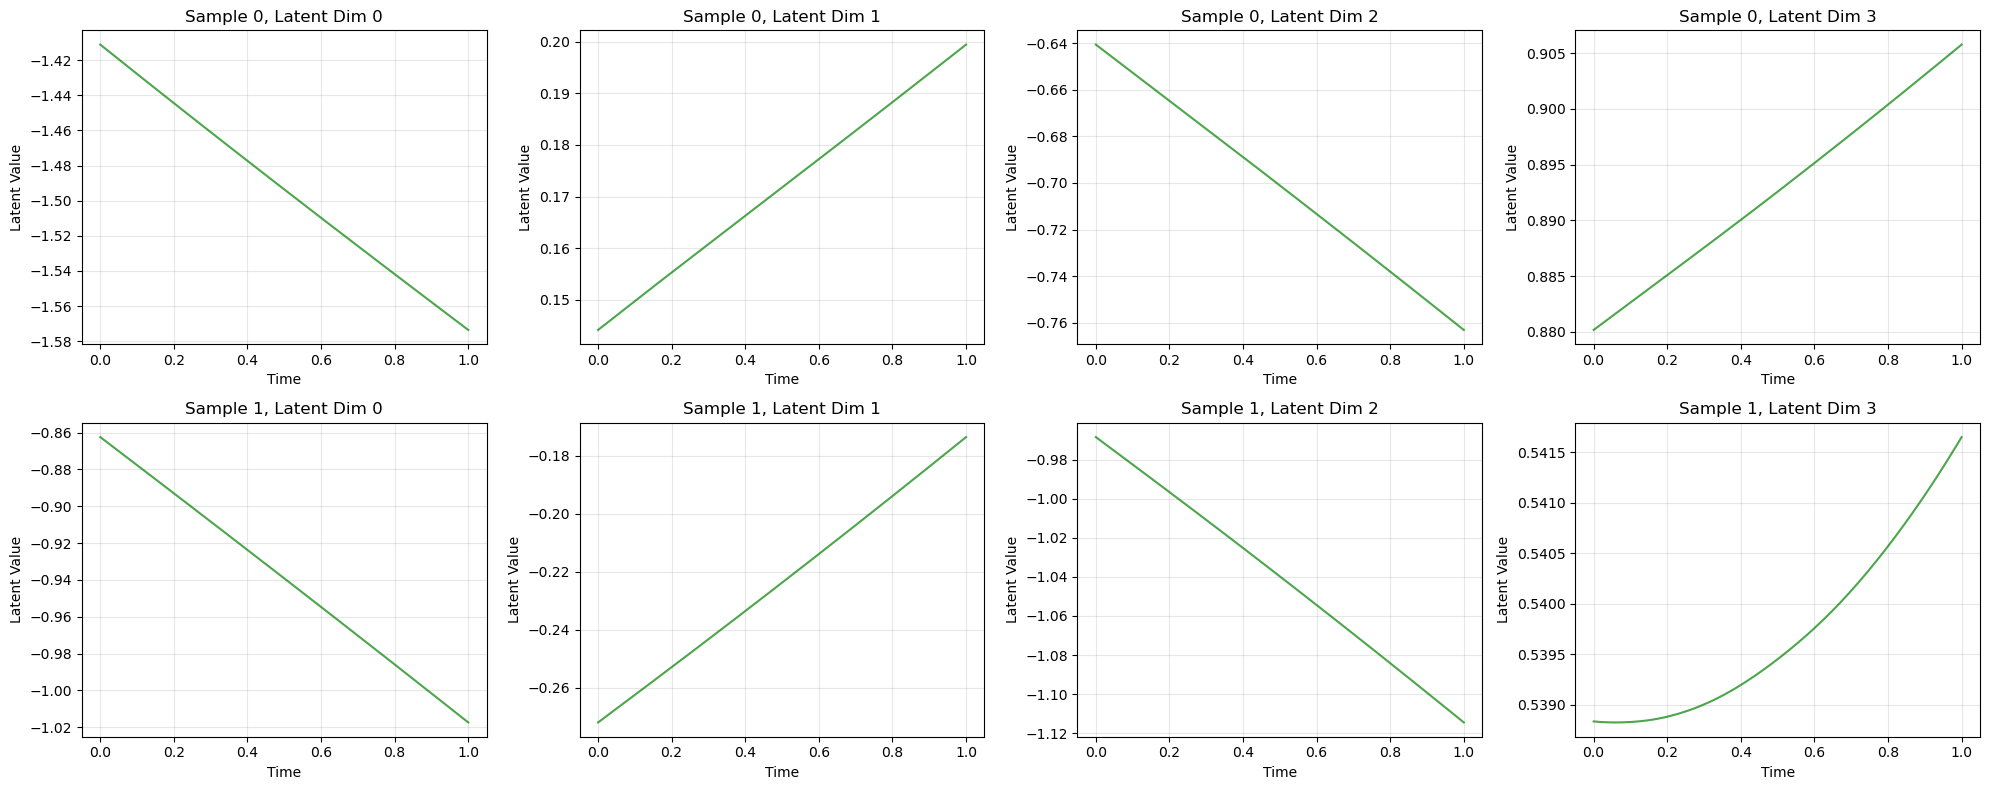


6. Starting training with detailed monitoring...
Epoch 0, Batch 0/113: Loss=1691174.5000, Recon=7018.1201, KL=1.0146, MSE=1.4044, Deriv=1.1201,  FP_std=0.4429
Epoch 0, Batch 22/113: Loss=283810.2812, Recon=8379.8594, KL=0.8639, MSE=1.6767, Deriv=1.0200,  FP_std=0.6655
Epoch 0, Batch 44/113: Loss=118331.0078, Recon=8847.2148, KL=0.9477, MSE=1.7702, Deriv=1.0767,  FP_std=0.7133
Epoch 0, Batch 66/113: Loss=77669.1797, Recon=7230.4619, KL=0.9306, MSE=1.4468, Deriv=1.1109,  FP_std=0.6484
Epoch 0, Batch 88/113: Loss=41602.7617, Recon=8706.2812, KL=0.8862, MSE=1.7420, Deriv=0.9430,  FP_std=0.6336
Epoch 0, Batch 110/113: Loss=98966.1797, Recon=7239.6396, KL=0.9508, MSE=1.4487, Deriv=1.1994,  FP_std=0.5246

--- Epoch 0 ECG Reconstructions ---


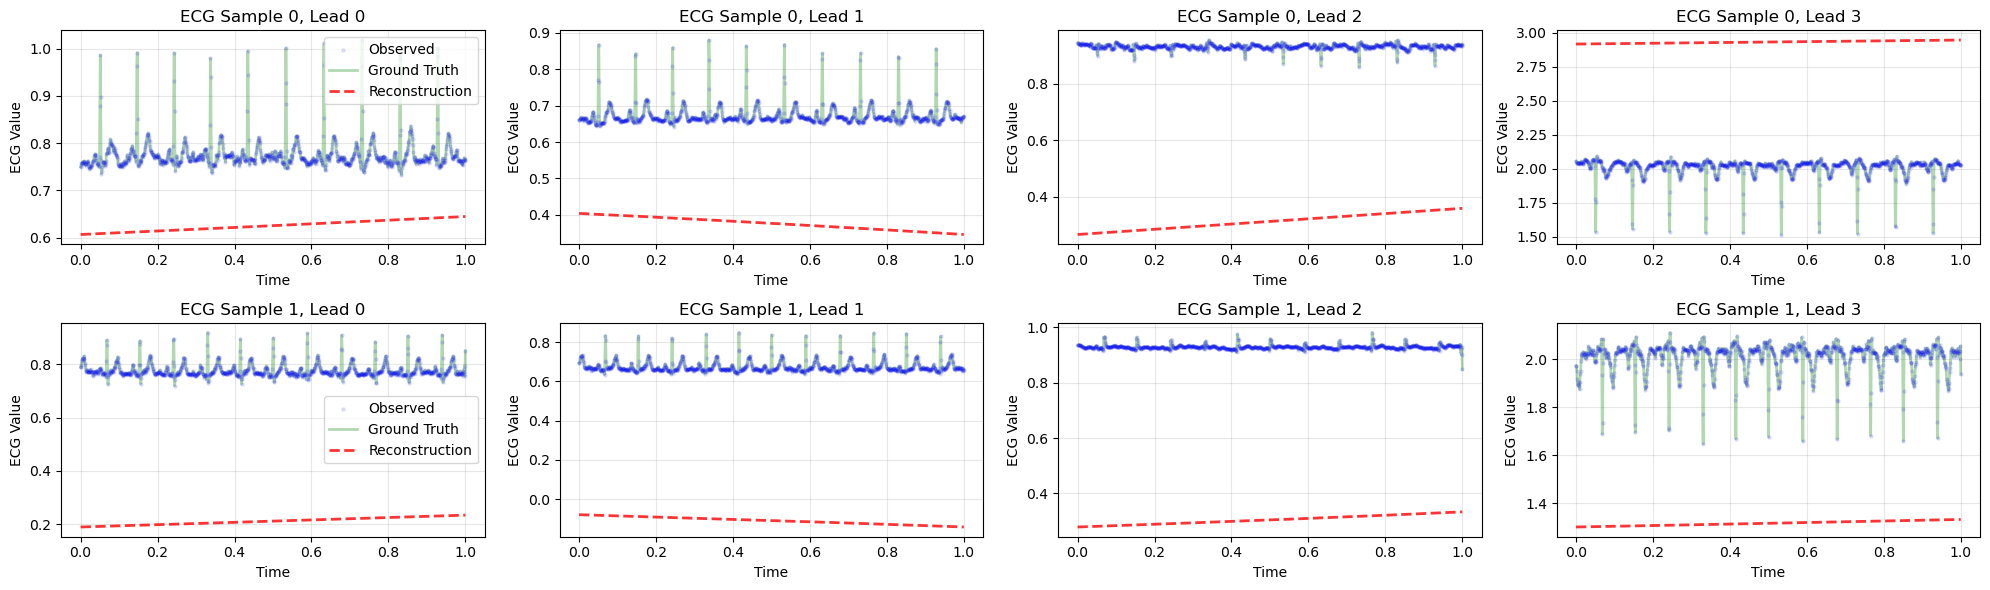

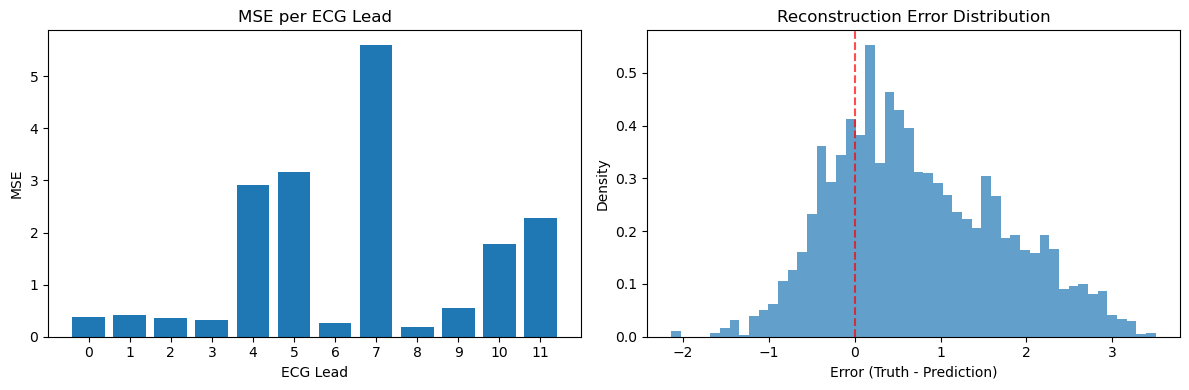

Overall MSE: 1.516879
Overall MAE: 0.948481
Error std: 0.989811


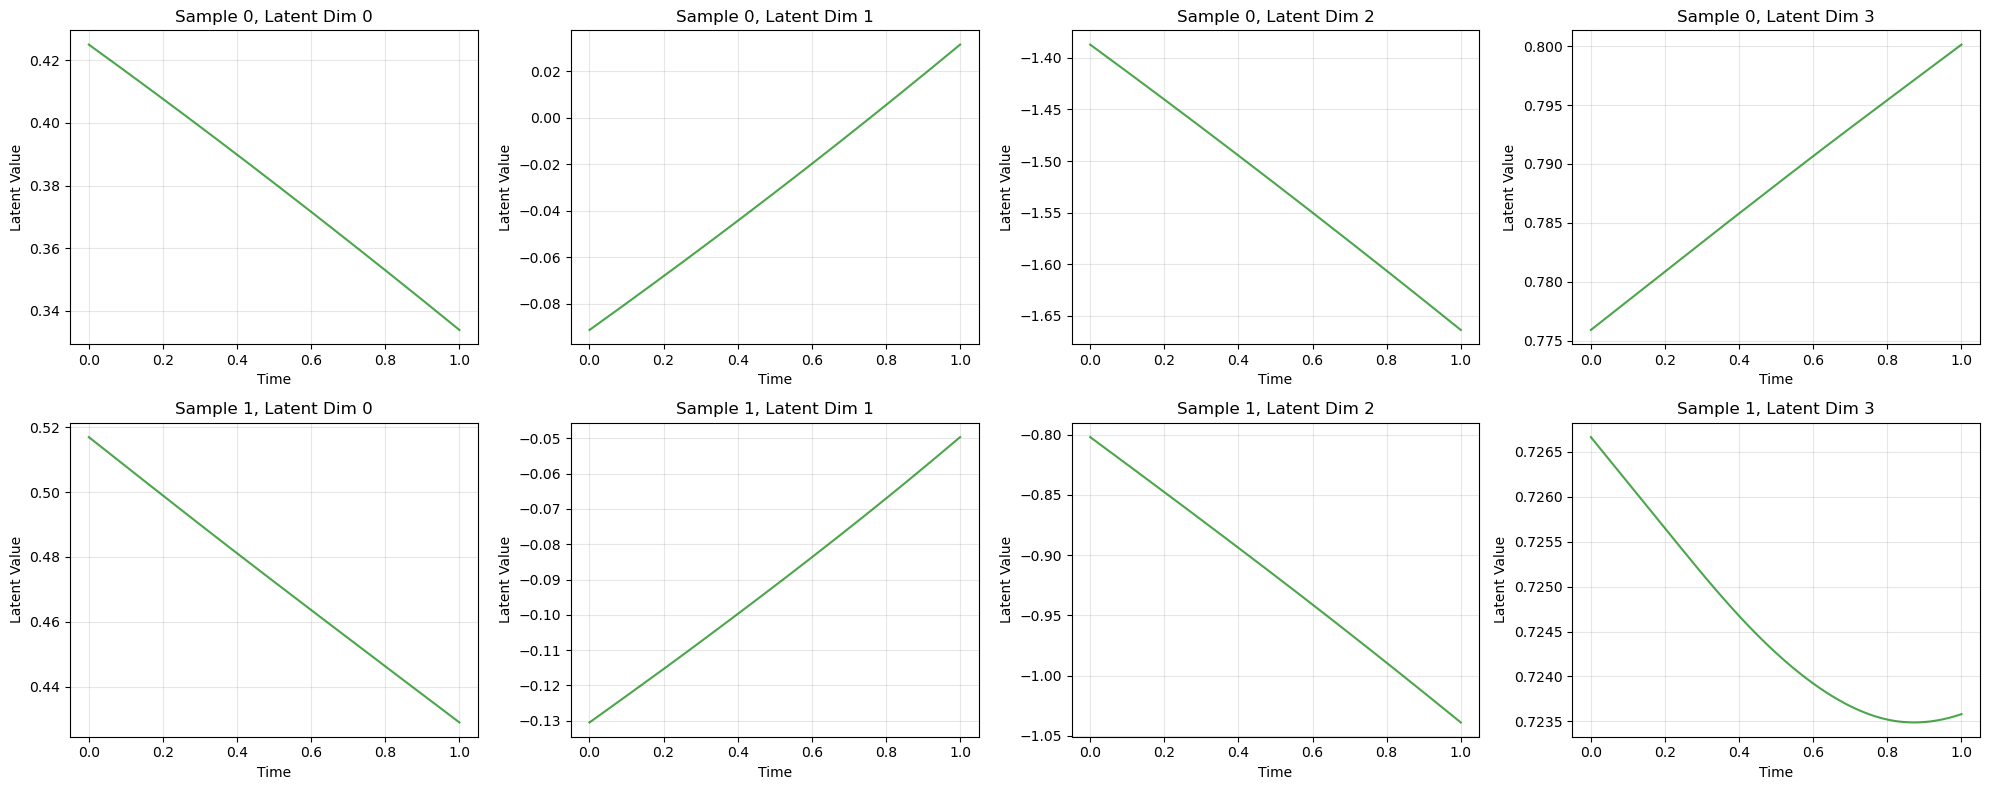

Epoch 1, Batch 0/113: Loss=42163.4180, Recon=8038.2637, KL=0.9441, MSE=1.6084, Deriv=1.1265,  FP_std=0.5185


KeyboardInterrupt: 

In [107]:
debug_training_pipeline()